In [ ]:
# STEP 1: Install Kaggle API and import necessary libraries
!pip install -q kaggle
import os
import zipfile

# STEP 2: Create the Kaggle directory and upload kaggle.json (already done by you)
kaggle_path = "/root/.kaggle"
os.makedirs(kaggle_path, exist_ok=True)
# If not uploaded, you'd use:
# from google.colab import files
# files.upload()  # upload kaggle.json manually here

# STEP 3: Move kaggle.json to the correct directory
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# STEP 4: Download the dataset from Kaggle
!kaggle datasets download -d debeshjha1/kvasirseg

# STEP 5: Unzip the dataset
with zipfile.ZipFile("kvasirseg.zip", 'r') as zip_ref:
    zip_ref.extractall("kvasirseg")

# STEP 6: Verify the extracted contents
import os
base_path = "kvasirseg/Kvasir-SEG"
for root, dirs, files in os.walk(base_path):
    print(f"{root}: {len(files)} files")


Dataset URL: https://www.kaggle.com/datasets/debeshjha1/kvasirseg
License(s): copyright-authors
 78% 112M/144M [00:00<00:00, 1.17GB/s]
100% 144M/144M [00:00<00:00, 1.03GB/s]
kvasirseg/Kvasir-SEG: 0 files
kvasirseg/Kvasir-SEG/Kvasir-SEG: 1 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/images: 1000 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/annotated_images: 1000 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/masks: 1000 files
kvasirseg/Kvasir-SEG/Kvasir-SEG/bbox: 1000 files


In [ ]:
import os

def print_limited_structure(folder_path, file_limit=2):
    for root, dirs, files in os.walk(folder_path):
        level = root.replace(folder_path, '').count(os.sep)
        indent = '    ' * level
        print(f"{indent}{os.path.basename(root)}/")

        sub_indent = '    ' * (level + 1)
        for i, f in enumerate(files):
            if i < file_limit:
                print(f"{sub_indent}{f}")
            elif i == file_limit:
                print(f"{sub_indent}... + {len(files) - file_limit} more files")
                break

# Example usage
folder_path = "kvasirseg/Kvasir-SEG"  # Change to your folder path
print_limited_structure(folder_path)


Kvasir-SEG/
    Kvasir-SEG/
        1911.07069.pdf
        images/
            cju8914beokbf0850isxpocrk.jpg
            cju424hy5lckr085073fva1ok.jpg
            ... + 998 more files
        annotated_images/
            cju8914beokbf0850isxpocrk.jpg
            cju424hy5lckr085073fva1ok.jpg
            ... + 998 more files
        masks/
            cju8914beokbf0850isxpocrk.jpg
            cju424hy5lckr085073fva1ok.jpg
            ... + 998 more files
        bbox/
            cju2zdvjn9h7r08553cp4eed5.csv
            cju32phw2bv130801yj7bkouq.csv
            ... + 998 more files


In [ ]:
import pandas as pd
import os

bbox_dir = "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG/bbox"
image_dir = "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images"

# Read one sample
csv_file = os.path.join(bbox_dir, "cju843yjskhq30818qre4rwm2.csv")
df = pd.read_csv(csv_file)
print(df.head())


  class_name  xmin  ymin  xmax  ymax
0      polyp   334    84   429   299


In [ ]:
import os
import pandas as pd
from PIL import Image
import shutil
import random

# Set paths
base_dir = "/content/kvasirseg"
images_dir = os.path.join(base_dir, "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images")
bbox_dir = os.path.join(base_dir, "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG/bbox")

# Output folders
output_dir = "kvasir_yolo"
images_output = os.path.join(output_dir, "images")
labels_output = os.path.join(output_dir, "labels")

for folder in ["train", "val"]:
    os.makedirs(os.path.join(images_output, folder), exist_ok=True)
    os.makedirs(os.path.join(labels_output, folder), exist_ok=True)

# Helper to convert to YOLO format
def convert_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return [x_center, y_center, width, height]

# Prepare dataset list
all_files = [f for f in os.listdir(bbox_dir) if f.endswith(".csv")]
random.shuffle(all_files)
split_idx = int(len(all_files) * 0.8)
train_files = all_files[:split_idx]
val_files = all_files[split_idx:]

def process_files(file_list, split):
    for csv_file in file_list:
        image_id = csv_file.replace(".csv", "")
        image_path = os.path.join(images_dir, image_id + ".jpg")
        label_path = os.path.join(labels_output, split, image_id + ".txt")

        if not os.path.exists(image_path):
            continue

        # Load image to get size
        with Image.open(image_path) as img:
            w, h = img.size

        # Read bbox CSV
        df = pd.read_csv(os.path.join(bbox_dir, csv_file))

        # Write YOLO format
        with open(label_path, "w") as f:
            for _, row in df.iterrows():
                if row['class_name'].lower() != 'polyp':
                    continue
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                x_center, y_center, width, height = convert_bbox(xmin, ymin, xmax, ymax, w, h)
                f.write(f"0 {x_center} {y_center} {width} {height}\n")

        # Copy image
        shutil.copy(image_path, os.path.join(images_output, split, image_id + ".jpg"))

# Process all files
process_files(train_files, "train")
process_files(val_files, "val")

# Create data.yaml
yaml_text = f"""
path: {os.path.abspath(output_dir)}
train: images/train
val: images/val

nc: 1
names: ['polyp']
"""

with open(os.path.join(output_dir, "data.yaml"), "w") as f:
    f.write(yaml_text.strip())

print("✅ YOLO dataset prepared successfully!")



✅ YOLO dataset prepared successfully!


In [ ]:
import os
import pandas as pd
from PIL import Image
import shutil
import random

# Set paths
base_dir = "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG"
images_dir = os.path.join(base_dir, "images")
bbox_dir = os.path.join(base_dir, "bbox")

# Output folders
output_dir = "kvasir_yolo"
images_output = os.path.join(output_dir, "images")
labels_output = os.path.join(output_dir, "labels")

for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_output, folder), exist_ok=True)
    os.makedirs(os.path.join(labels_output, folder), exist_ok=True)

# Helper to convert to YOLO format
def convert_bbox(xmin, ymin, xmax, ymax, img_w, img_h):
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return [x_center, y_center, width, height]

# Prepare dataset list
all_files = [f for f in os.listdir(bbox_dir) if f.endswith(".csv")]
random.shuffle(all_files)

# Split into 70% train, 15% val, 15% test
total = len(all_files)
train_split = int(total * 0.7)
val_split = int(total * 0.85)

train_files = all_files[:train_split]
val_files = all_files[train_split:val_split]
test_files = all_files[val_split:]

def process_files(file_list, split):
    for csv_file in file_list:
        image_id = csv_file.replace(".csv", "")
        image_path = os.path.join(images_dir, image_id + ".jpg")
        label_path = os.path.join(labels_output, split, image_id + ".txt")

        if not os.path.exists(image_path):
            continue

        # Load image
        with Image.open(image_path) as img:
            w, h = img.size

        # Read bbox CSV
        df = pd.read_csv(os.path.join(bbox_dir, csv_file))

        # Write YOLO txt label
        with open(label_path, "w") as f:
            for _, row in df.iterrows():
                if row['class_name'].lower() != 'polyp':
                    continue
                xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
                x_center, y_center, width, height = convert_bbox(xmin, ymin, xmax, ymax, w, h)
                f.write(f"0 {x_center} {y_center} {width} {height}\n")

        # Copy image
        shutil.copy(image_path, os.path.join(images_output, split, image_id + ".jpg"))

# Process each split
process_files(train_files, "train")
process_files(val_files, "val")
process_files(test_files, "test")

# Create data.yaml (Note: test isn't used in YOLOv5 training, only for eval manually)
yaml_text = f"""
path: {os.path.abspath(output_dir)}
train: images/train
val: images/val

nc: 1
names: ['polyp']
"""

with open(os.path.join(output_dir, "data.yaml"), "w") as f:
    f.write(yaml_text.strip())

print("✅ YOLO dataset with train, val, and test prepared successfully!")


✅ YOLO dataset with train, val, and test prepared successfully!


In [ ]:
!pip install ultralytics


In [ ]:
from ultralytics import YOLO
import numpy as np
import cv2



In [ ]:
from ultralytics import YOLO
import numpy as np
import cv2


Found existing installation: torch 2.1.0
Uninstalling torch-2.1.0:
  Successfully uninstalled torch-2.1.0
Found existing installation: torchvision 0.16.0
Uninstalling torchvision-0.16.0:
  Successfully uninstalled torchvision-0.16.0
Found existing installation: torchaudio 2.1.0
Uninstalling torchaudio-2.1.0:
  Successfully uninstalled torchaudio-2.1.0
Found existing installation: ultralytics 8.0.208
Uninstalling ultralytics-8.0.208:
  Successfully uninstalled ultralytics-8.0.208
  Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.16.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached torchaudio-2.1.0-cp311-cp311-manylinux1_x86_64.whl.metadata (5.7 kB)
Using cached torch-2.1.0-cp311-cp311-manylinux1_x86_64.whl (670.2 MB)
Using cached torchvision-0.16.0-cp311-cp311-manylinux1_x86_64.whl (6.9 MB)
Using cached torchaudio-2.1.0-cp311-cp311-manylinux1_x86_64.whl (3.3 MB)
  Using cached ultralytics-8.0.208-py3-none-any.wh

Found existing installation: numpy 2.3.0
Uninstalling numpy-2.3.0:
  Successfully uninstalled numpy-2.3.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


here something missing


In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from tqdm import tqdm  # for progress bar

# Load model
model = YOLO("/content/best.pt")

# Directories
test_img_dir = "/content/kvasir_yolo/images/test"
test_label_dir = "/content/kvasir_yolo/labels/test"

# Compute IoU between 2 boxes
def compute_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = interArea / float(box1Area + box2Area - interArea + 1e-6)
    return iou

# Read YOLO-format ground truth
def read_gt_boxes(label_path, img_shape):
    h, w = img_shape[:2]
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            boxes.append((x1, y1, x2, y2))
    return boxes

# === Main Evaluation ===
image_paths = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(".jpg")]

all_ious = []

for img_path in tqdm(image_paths, desc="Evaluating"):
    img = cv2.imread(img_path)
    if img is None:
        continue
    h, w = img.shape[:2]

    # Ground truth boxes
    label_path = os.path.join(test_label_dir, os.path.basename(img_path).replace(".jpg", ".txt"))
    gt_boxes = read_gt_boxes(label_path, img.shape)

    # Prediction
    results = model(img_path, verbose=False)
    pred_boxes = results[0].boxes.xyxy.cpu().numpy() if results[0].boxes.xyxy is not None else []

    # Match predictions to ground truths
    for pb in pred_boxes:
        pred_box = tuple(map(int, pb[:4]))
        best_iou = 0
        for gt_box in gt_boxes:
            iou = compute_iou(pred_box, gt_box)
            best_iou = max(best_iou, iou)
        all_ious.append(best_iou)

# === Final IoU Score ===
if all_ious:
    mean_iou = np.mean(all_ious)
    print(f"\n✅ Total test images: {len(image_paths)}")
    print(f"📏 Total matched predictions: {len(all_ious)}")
    print(f"📊 Average IoU over test set: {mean_iou:.4f}")
else:
    print("⚠️ No IoU could be calculated. Check labels or predictions.")



Evaluating: 100%|██████████| 481/481 [04:38<00:00,  1.73it/s]


✅ Total test images: 481
📏 Total matched predictions: 570
📊 Average IoU over test set: 0.8235


🔍 Showing predictions on test images...



image 1/1 /content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/cju8ayeq7r1fb0818z1junacy.jpg: 576x640 1 polyp, 548.5ms
Speed: 4.5ms preprocess, 548.5ms inference, 10.5ms postprocess per image at shape (1, 3, 576, 640)


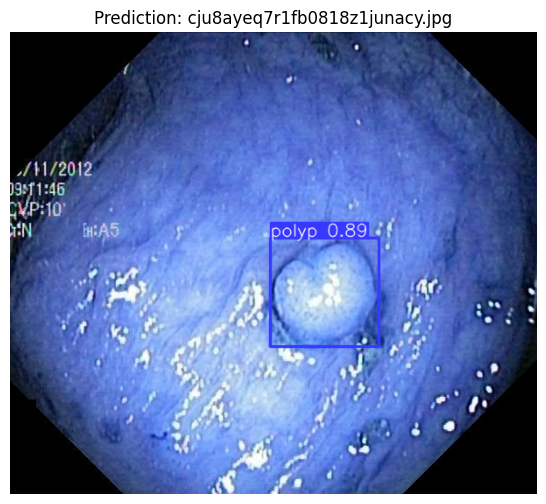


image 1/1 /content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/cju2igw4gvxds0878808qj398.jpg: 576x640 1 polyp, 562.7ms
Speed: 7.5ms preprocess, 562.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


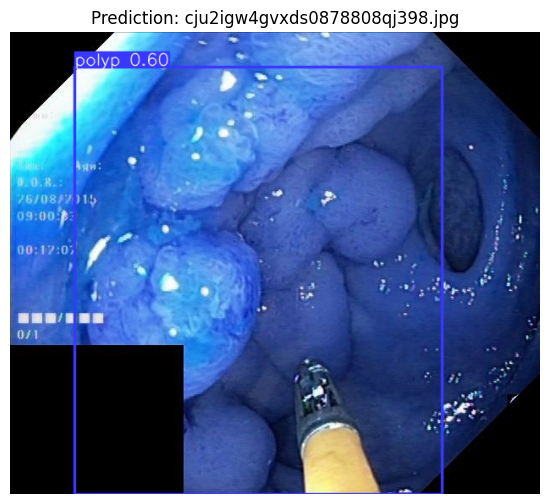


image 1/1 /content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/cju45ofd9ne1j0801ri8dup7t.jpg: 576x640 1 polyp, 524.8ms
Speed: 7.3ms preprocess, 524.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


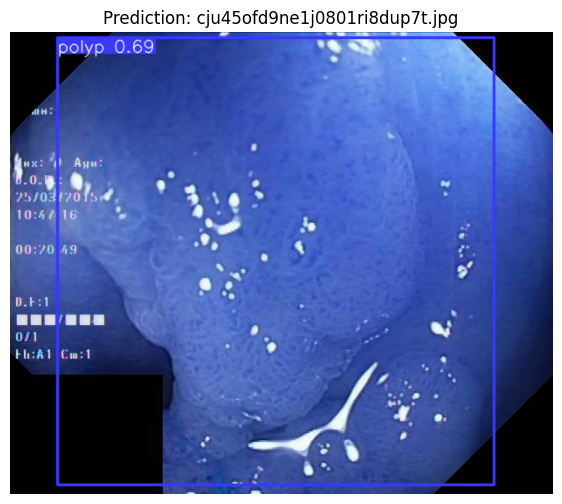


image 1/1 /content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/cju1cvkfwqrec0993wbp1jlzm.jpg: 576x640 2 polyps, 542.9ms
Speed: 6.4ms preprocess, 542.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


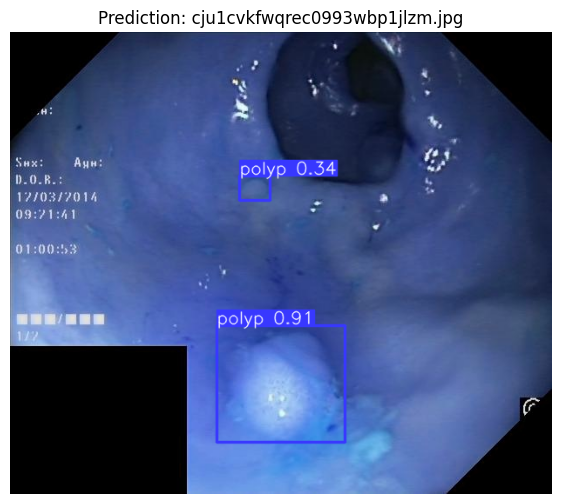


image 1/1 /content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images/cju6vvb8svhed0801jjcquh5e.jpg: 576x640 1 polyp, 542.6ms
Speed: 5.6ms preprocess, 542.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


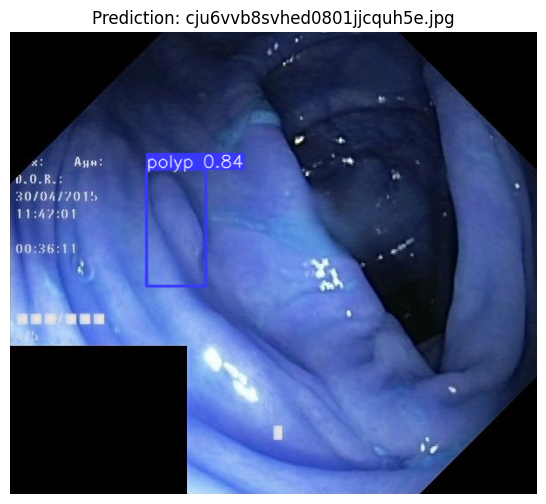

📊 Plotting evaluation metrics over epochs...
❌ results.csv not found. Make sure training is complete and metrics were saved.


In [ ]:
from ultralytics import YOLO
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# ==== 1. Load your trained model ====
model = YOLO("/content/best.pt")

# ==== 2. Predict and Display Test Images ====
test_img_dir = "/content/kvasirseg/Kvasir-SEG/Kvasir-SEG/images"
image_paths = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(".jpg")]

print("🔍 Showing predictions on test images...")
for i, img_path in enumerate(image_paths[:5]):  # Show first 5 test images
    results = model(img_path)
    img = results[0].plot()  # Get numpy image with boxes

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {os.path.basename(img_path)}")
    plt.show()

# ==== 3. Plot training metrics from results.csv ====
print("📊 Plotting evaluation metrics over epochs...")
results_csv = "runs/detect/train/results.csv"

if os.path.exists(results_csv):
    df = pd.read_csv(results_csv)

    plt.figure(figsize=(12, 6))
    plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')

    plt.title("📈 Evaluation Metrics During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("❌ results.csv not found. Make sure training is complete and metrics were saved.")



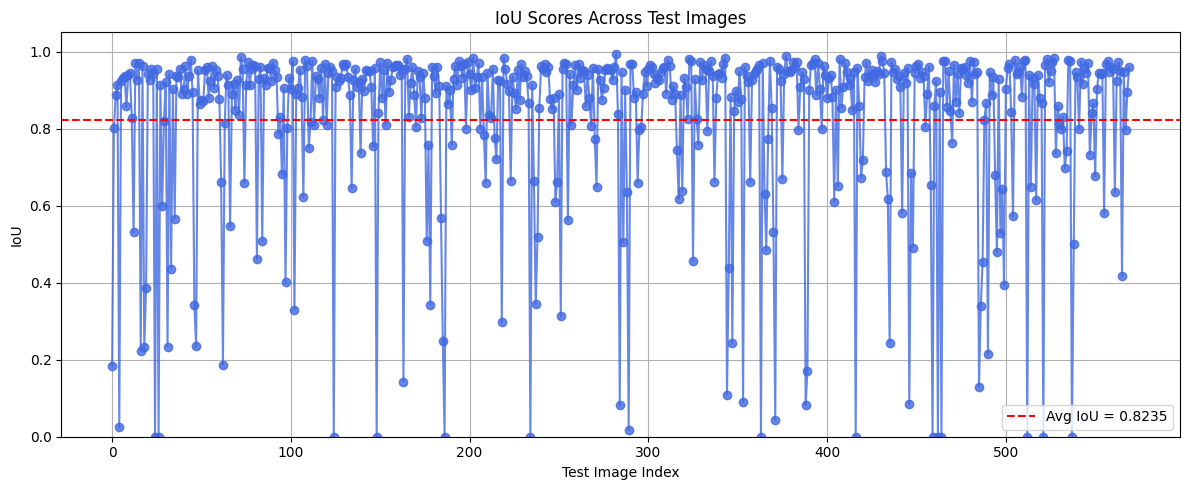

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_ious already exists from your evaluation loop
plt.figure(figsize=(12, 5))
plt.plot(all_ious, marker='o', linestyle='-', color='royalblue', alpha=0.8)
plt.title("IoU Scores Across Test Images")
plt.xlabel("Test Image Index")
plt.ylabel("IoU")
plt.ylim(0, 1.05)
plt.grid(True)
plt.axhline(y=np.mean(all_ious), color='red', linestyle='--', label=f'Avg IoU = {np.mean(all_ious):.4f}')
plt.legend()
plt.tight_layout()
plt.show()


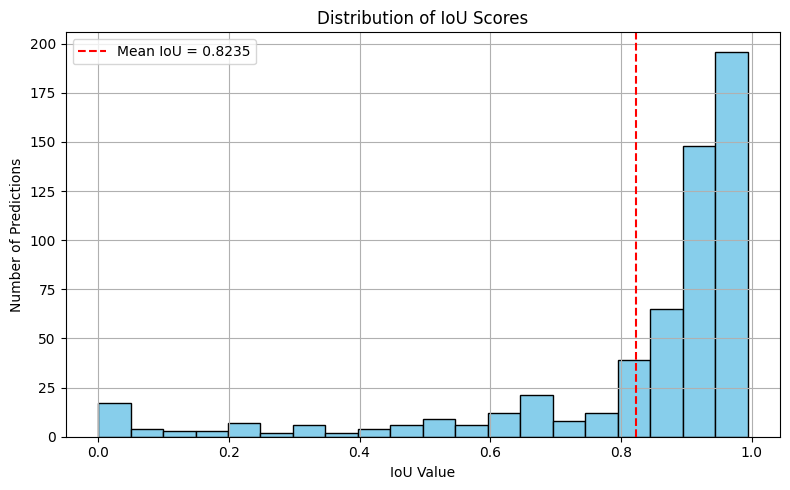

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(all_ious, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of IoU Scores")
plt.xlabel("IoU Value")
plt.ylabel("Number of Predictions")
plt.axvline(np.mean(all_ious), color='red', linestyle='--', label=f'Mean IoU = {np.mean(all_ious):.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from ultralytics import YOLO

# Load the trained model
model = YOLO("/content/best.pt")

# Evaluate on the test set
metrics = model.val(data="/content/kvasir_yolo/data.yaml", split="test")



Ultralytics YOLOv8.0.208 🚀 Python-3.11.13 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv5s summary (fused): 193 layers, 9111923 parameters, 0 gradients, 23.8 GFLOPs


FileNotFoundError: Dataset '/content/kvasirseg/val.txt' for task=detect not found ❌

In [ ]:
print("\n📋 Evaluation Metrics on Test Set:")

precision  = metrics.box.mp            # Mean precision
recall     = metrics.box.mr            # Mean recall
map50      = metrics.box.map50         # mAP at IoU=0.5
map5095    = metrics.box.map           # mAP at IoU=0.5:0.95
fitness    = metrics.fitness           # Fitness score

print(f"🔹 Precision      : {precision:.4f}")
print(f"🔹 Recall         : {recall:.4f}")
print(f"🔹 mAP@0.5        : {map50:.4f}")
print(f"🔹 mAP@0.5:0.95   : {map5095:.4f}")
print(f"📈 Fitness Score : {fitness:.4f}")




📋 Evaluation Metrics on Test Set:
🔹 Precision      : 0.8924
🔹 Recall         : 0.8773
🔹 mAP@0.5        : 0.9358
🔹 mAP@0.5:0.95   : 0.7624
📈 Fitness Score : 0.7798



image 1/1 /content/kvasir_yolo/images/test/cju1c8ffau5770835g0g343o8.jpg: 544x640 1 polyp, 15.0ms
Speed: 2.8ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


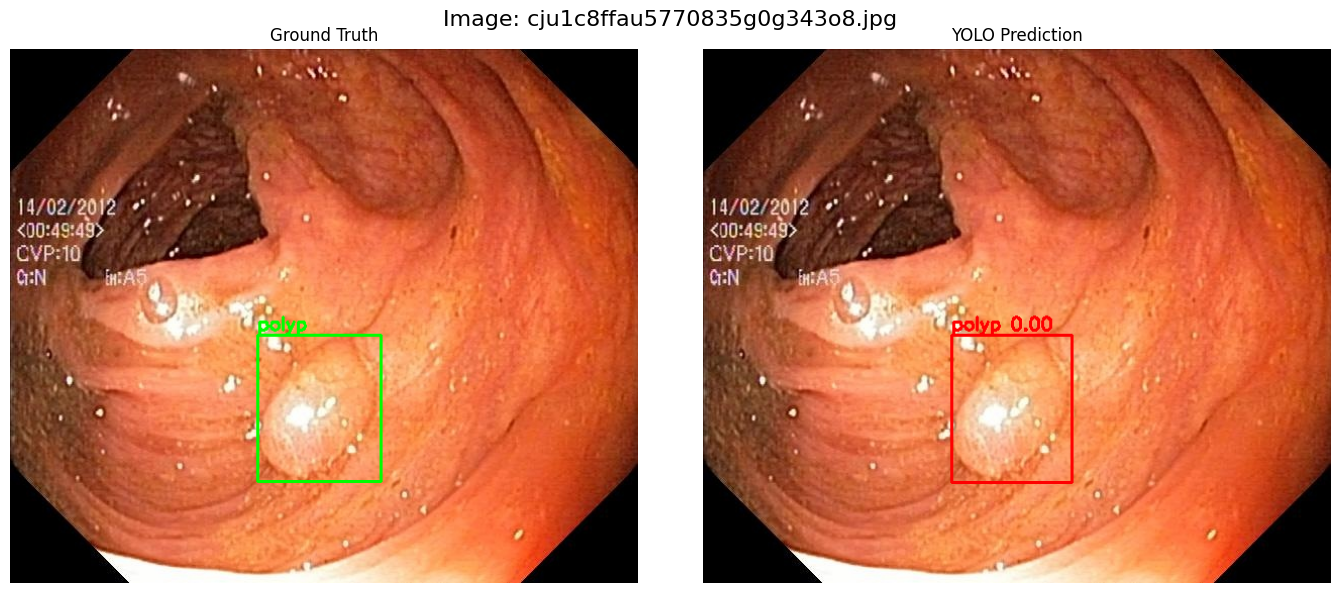


image 1/1 /content/kvasir_yolo/images/test/cju89z6pqpqfx0817mfv8ixjc.jpg: 576x640 (no detections), 16.5ms
Speed: 3.9ms preprocess, 16.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


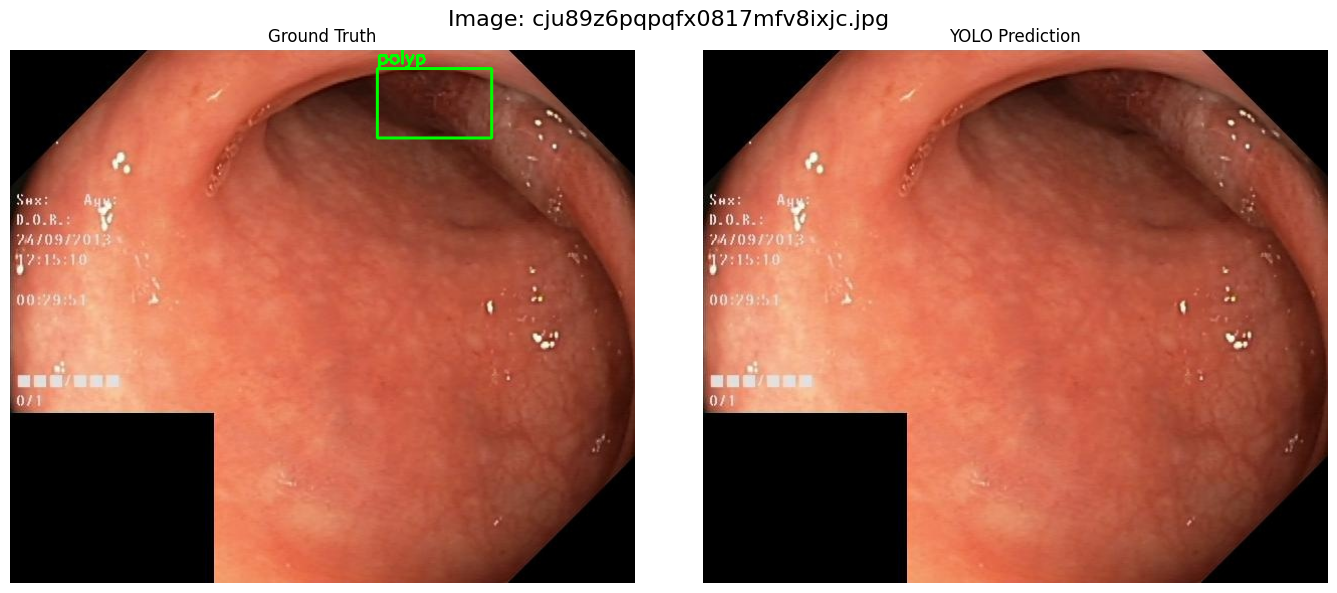


image 1/1 /content/kvasir_yolo/images/test/cju3ttznuftyf09875t11850w.jpg: 576x640 1 polyp, 14.6ms
Speed: 4.1ms preprocess, 14.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


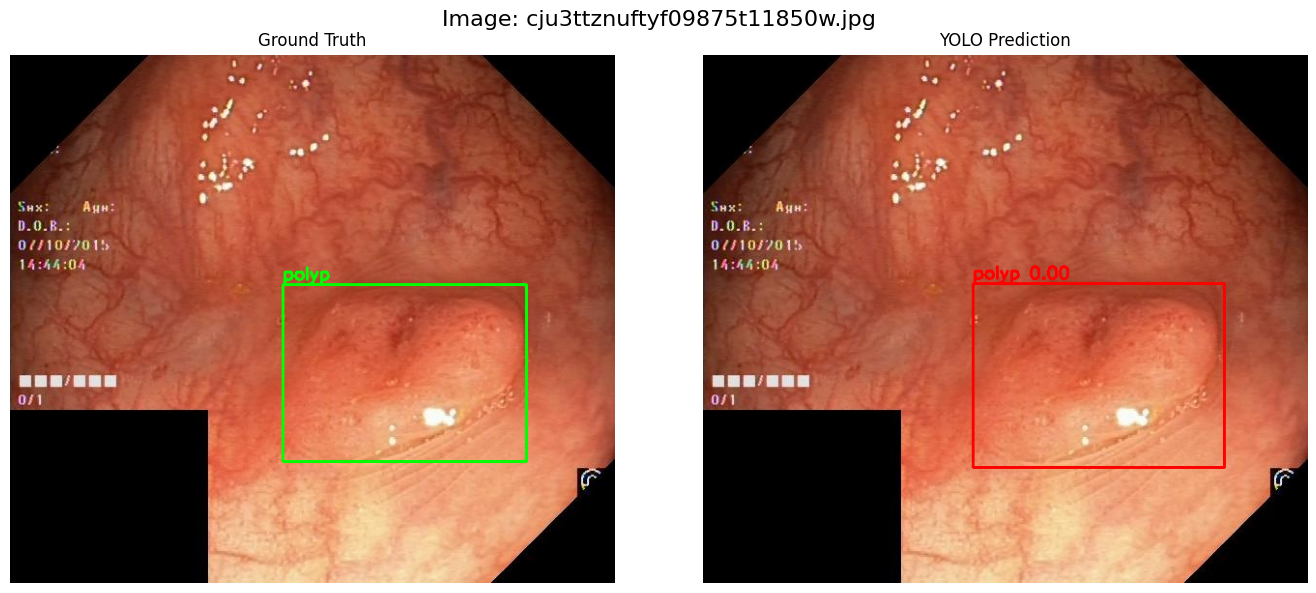


image 1/1 /content/kvasir_yolo/images/test/cju2top2ruxxy0988p1svx36g.jpg: 608x640 1 polyp, 15.8ms
Speed: 4.2ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


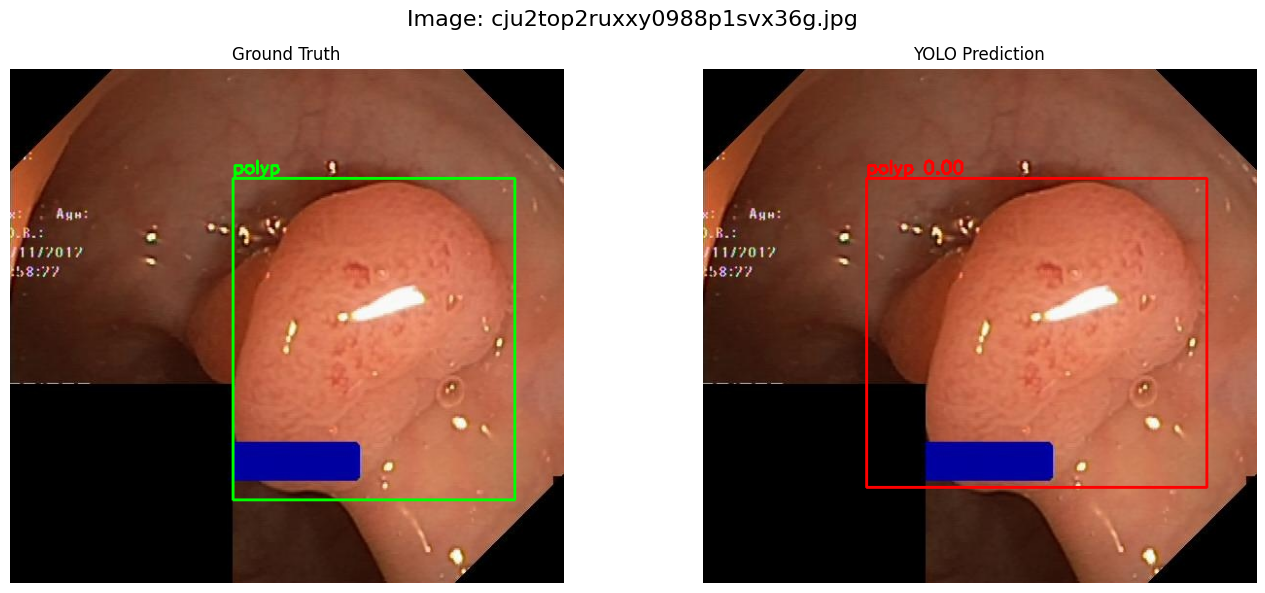


image 1/1 /content/kvasir_yolo/images/test/cju353d1eda8c07992afde611.jpg: 544x640 1 polyp, 15.5ms
Speed: 3.9ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


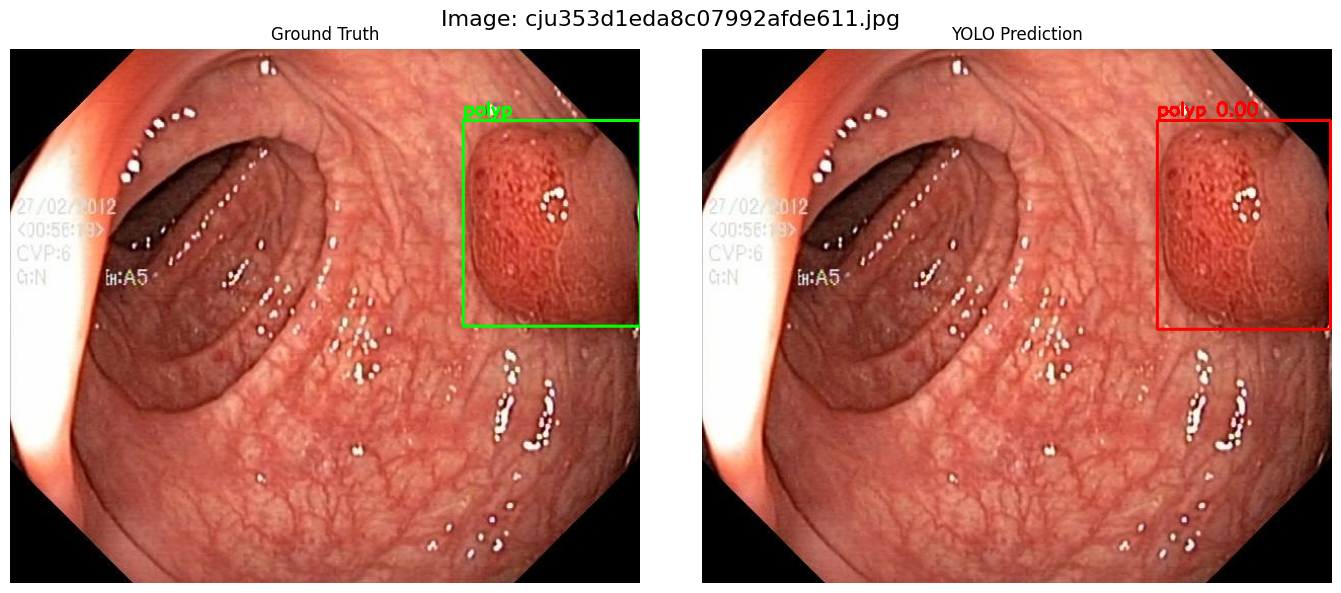

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# === Paths ===
img_dir = "/content/kvasir_yolo/images/test"
label_dir = "/content/kvasir_yolo/labels/test"
model = YOLO("runs/detect/train/weights/best.pt")

# Class names (only 'polyp')
class_names = ['polyp']

# Helper: Read ground truth labels from YOLO format
def read_ground_truth(label_path, img_shape):
    h, w = img_shape[:2]
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            boxes.append(((x1, y1, x2, y2), int(cls)))
    return boxes

# ==== Visualization ====
image_names = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

for name in image_names:
    img_path = os.path.join(img_dir, name)
    label_path = os.path.join(label_dir, name.replace(".jpg", ".txt"))

    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pred = img_rgb.copy()
    img_gt = img_rgb.copy()

    # ==== Draw ground truth ====
    gt_boxes = read_ground_truth(label_path, img_rgb.shape)
    for (x1, y1, x2, y2), cls_id in gt_boxes:
        cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green
        cv2.putText(img_gt, class_names[cls_id], (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # ==== Predict and draw ====
    results = model(img_path)
    for box in results[0].boxes.data.tolist():
        x1, y1, x2, y2, conf, cls_id = map(int, box[:6])
        cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue
        cv2.putText(img_pred, f"{class_names[cls_id]} {conf:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # ==== Show side by side ====
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].imshow(img_gt)
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(img_pred)
    axs[1].set_title("YOLO Prediction")
    axs[1].axis("off")

    plt.suptitle(f"Image: {name}", fontsize=16)
    plt.tight_layout()
    plt.show()




image 1/1 /content/kvasir_yolo/images/test/cju1c8ffau5770835g0g343o8.jpg: 544x640 1 polyp, 16.5ms
Speed: 3.6ms preprocess, 16.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


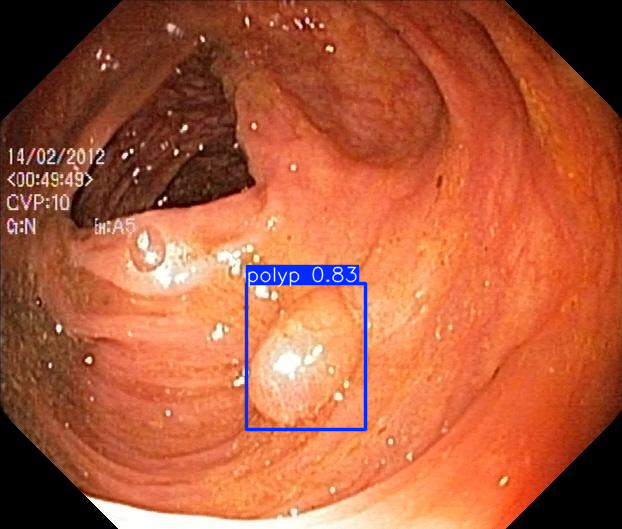


image 1/1 /content/kvasir_yolo/images/test/cju89z6pqpqfx0817mfv8ixjc.jpg: 576x640 (no detections), 23.9ms
Speed: 3.7ms preprocess, 23.9ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 640)


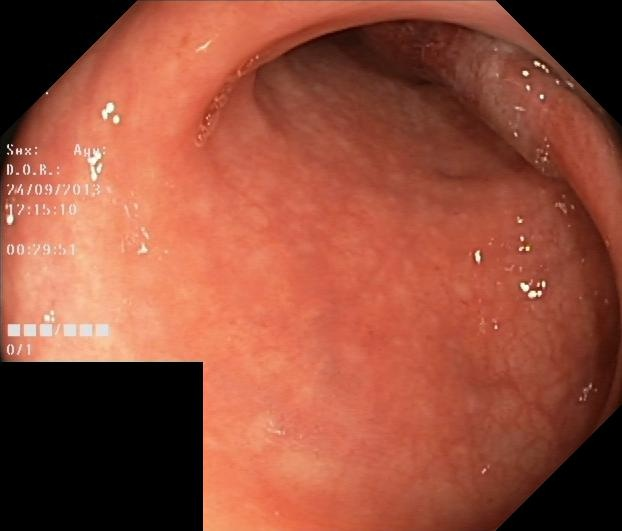


image 1/1 /content/kvasir_yolo/images/test/cju3ttznuftyf09875t11850w.jpg: 576x640 1 polyp, 17.2ms
Speed: 4.1ms preprocess, 17.2ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 640)


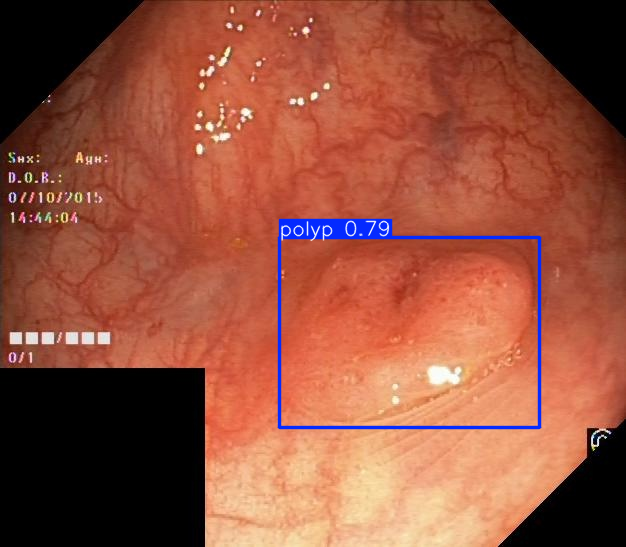


image 1/1 /content/kvasir_yolo/images/test/cju2top2ruxxy0988p1svx36g.jpg: 608x640 1 polyp, 18.2ms
Speed: 4.3ms preprocess, 18.2ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


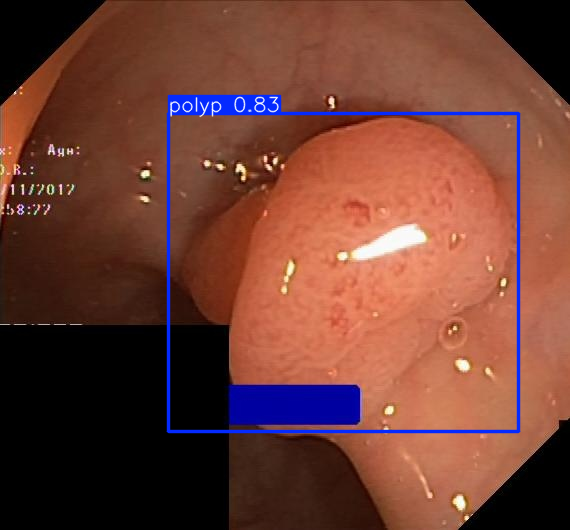


image 1/1 /content/kvasir_yolo/images/test/cju353d1eda8c07992afde611.jpg: 544x640 1 polyp, 45.7ms
Speed: 10.4ms preprocess, 45.7ms inference, 38.3ms postprocess per image at shape (1, 3, 544, 640)


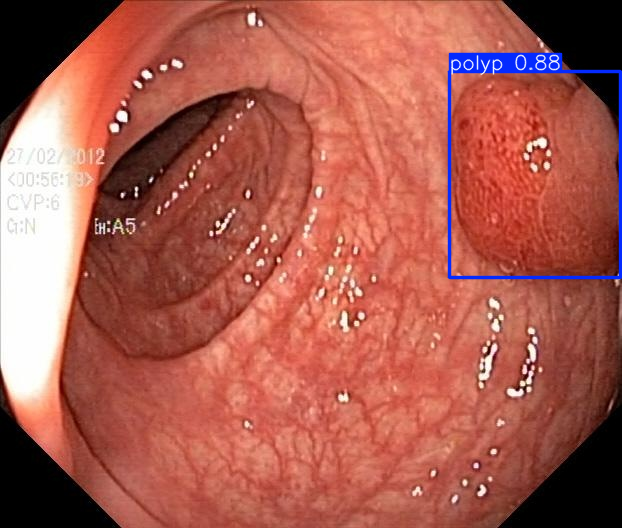

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Path to unseen images (test set)
img_dir = "/content/kvasir_yolo/images/test"

# Get list of images
import os
img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".jpg")]

# Run prediction and show result for each image
for i, img_path in enumerate(img_paths[:5]):  # change [:5] to see more images
    results = model(img_path)  # returns Results object

    # Plot the result (with boxes) using built-in method
    results[0].plot(show=True)  # Opens the image inline with bounding boxes in Colab



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:
# 1. Clone the YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

# 2. Change directory into yolov5
%cd yolov5

# 3. Install all requirements (includes PyTorch, matplotlib, OpenCV, etc.)
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17496, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17496 (delta 2), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17496/17496), 16.54 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (11990/11990), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:0

In [ ]:
custom_yolo_arch = '''# YOLOv5s Custom Model
nc: 1
depth_multiple: 0.33
width_multiple: 0.50

anchors:
  - [10,13, 16,30, 33,23]
  - [30,61, 62,45, 59,119]
  - [116,90, 156,198, 373,326]

backbone:
  [
    [ -1, 1, Focus, [64, 3] ],
    [ -1, 1, Conv, [128, 3, 2] ],
    [ -1, 3, BottleneckCSP, [128] ],
    [ -1, 1, Conv, [256, 3, 2] ],
    [ -1, 9, BottleneckCSP, [256] ],
    [ -1, 1, Conv, [512, 3, 2] ],
    [ -1, 9, BottleneckCSP, [512] ],
    [ -1, 1, Conv, [1024, 3, 2] ],
    [ -1, 1, SPP, [1024, [5, 9, 13]] ],
    [ -1, 3, BottleneckCSP, [1024, False] ]
  ]

head:
  [
    [ -1, 1, Conv, [512, 1, 1] ],
    [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ],
    [ [ -1, 6 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [512] ],

    [ -1, 1, Conv, [256, 1, 1] ],
    [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ],
    [ [ -1, 4 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [256] ],

    [ -1, 1, Conv, [256, 3, 2] ],
    [ [ -1, 14 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [512] ],

    [ -1, 1, Conv, [512, 3, 2] ],
    [ [ -1, 10 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [1024] ],

    [ [17, 20, 23], 1, Detect, [nc, anchors] ]
  ]
'''

with open('/content/yolov5/models/mycustom_yolov5s.yaml', 'w') as f:
    f.write(custom_yolo_arch.strip())


In [ ]:
# 🚫 Disable W&B tracking completely
import os
os.environ['WANDB_MODE'] = 'disabled'

# Your imports and class TrainArgs...

opt = argparse.Namespace(**TrainArgs().__dict__)
opt.nolog = True  # 👈 MUST be included

NameError: name 'TrainArgs' is not defined

In [ ]:
# ✅ STEP 1: Disable W&B prompts (no online logging)
import os
os.environ['WANDB_MODE'] = 'disabled'

# ✅ STEP 2: Import everything needed
import argparse
import torch
from yolov5.train import main as yolo_train   # ✅ use `main` if available; otherwise switch to `run`
from yolov5.val import run as yolo_val

# ✅ STEP 3: Define training parameters
class TrainArgs:
    def __init__(self):
        self.imgsz = 640
        self.batch_size = 16
        self.epochs = 5
        self.data = "/content/kvasir_yolo/data.yaml"
        self.cfg = "/content/yolov5/models/mycustom_yolov5s.yaml"
        self.weights = ''  # Start training from scratch
        self.name = "custom_yolov5s"
        self.project = "runs/train"
        self.optimizer = "Adam"
        self.patience = 20
        self.exist_ok = True
        self.save_period = 5
        self.device = '0'
        self.resume = False
        self.evolve = False
        self.nosave = False
        self.hyp = "/content/yolov5/data/hyps/hyp.scratch-low.yaml"
        self.single_cls = False
        self.noval = False
        self.workers = 8
        self.noplots = False
        self.seed = 0
        self.freeze = [0]
        self.cos_lr = False
        self.sync_bn = False
        self.cache = None
        self.rect = False
        self.image_weights = False
        self.quad = False
        self.noautoanchor = False
        self.label_smoothing = 0.0
        self.multi_scale = False
        self.nolog = True  # ✅ Fully disable W&B

# ✅ STEP 4: Convert parameters to argparse.Namespace format
opt = argparse.Namespace(**TrainArgs().__dict__)

# ✅ STEP 5: Train the YOLOv5 model
print("🚀 Training Started...")
yolo_train(opt)

# ✅ STEP 6: Evaluate the best model
print("📊 Evaluating best.pt...")

best_model_path = f"{opt.project}/{opt.name}/weights/best.pt"
if not os.path.exists(best_model_path):
    raise FileNotFoundError(f"❌ Model not found at: {best_model_path}")

results = yolo_val(
    data=opt.data,
    weights=best_model_path,
    imgsz=opt.imgsz,
    device=opt.device,
    conf_thres=0.001,
    iou_thres=0.6,
    plots=True,
    save_json=True
)

# ✅ STEP 7: Safely unpack and print evaluation metrics
print("\n✅ Evaluation Metrics:")
if len(results) == 3:
    map50, map50_95, iou = results
    print(f"✔ mAP@0.5       : {map50:.4f}")
    print(f"✔ mAP@0.5:0.95  : {map50_95:.4f}")
    print(f"✔ IoU (best guess): {iou:.4f}")
elif len(results) >= 4:
    map50, map50_95, precision, recall = results[:4]
    print(f"✔ mAP@0.5       : {map50:.4f}")
    print(f"✔ mAP@0.5:0.95  : {map50_95:.4f}")
    print(f"✔ Precision     : {precision:.4f}")
    print(f"✔ Recall        : {recall:.4f}")
else:
    print("❌ Unexpected result format from yolo_val(). Output:")
    print(results)



train: imgsz=640, batch_size=16, epochs=5, data=/content/kvasir_yolo/data.yaml, cfg=/content/yolov5/models/mycustom_yolov5s.yaml, weights=, name=custom_yolov5s, project=runs/train, optimizer=Adam, patience=20, exist_ok=True, save_period=5, device=0, resume=False, evolve=False, nosave=False, hyp=/content/yolov5/data/hyps/hyp.scratch-low.yaml, single_cls=False, noval=False, workers=8, noplots=False, seed=0, freeze=[0], cos_lr=False, sync_bn=False, cache=None, rect=False, image_weights=False, quad=False, noautoanchor=False, label_smoothing=0.0, multi_scale=False, nolog=True


🚀 Training Started...


github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
Comet: run 'pip install comet_ml' to automatically track and visualize YOLOv5 🚀 runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv    

📊 Evaluating best.pt...


mycustom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
val: Scanning /content/kvasir_yolo/labels/val.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 11/11 [00:08<00:00,  1.26it/s]
                   all        326        357     0.0199      0.549     0.0359    0.00879
Speed: 0.2ms pre-process, 3.4ms inference, 3.9ms NMS per image at shape (32, 3, 640, 640)

Evaluating pycocotools mAP... saving yolov5/runs/val/exp4/best_predictions.json...
pycocotools unable to run: [Errno 2] No such file or directory: '/content/kvasir_yolo/annotations/instances_val2017.json'
Results saved to yolov5/runs/val/exp4


loading annotations into memory...

✅ Evaluation Metrics:


TypeError: unsupported format string passed to tuple.__format__

**yolo5s customize model ............**
**bold text**

In [ ]:
from IPython.display import Image
Image(filename='runs/train/custom_yolov5s/results.png', width=800)



FileNotFoundError: [Errno 2] No such file or directory: 'runs/train/custom_yolov5s/results.png'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.0 MB/s eta 0:00:00


Attampt 03
for customize


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17496, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17496 (delta 2), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17496/17496), 16.54 MiB | 17.13 MiB/s, done.
Resolving deltas: 100% (11990/11990), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.8 MB/s eta 0:00:00


In [ ]:
import os
os.environ['WANDB_MODE'] = 'disabled'
os.environ['WANDB_DISABLED'] = 'true'



In [ ]:
custom_yolo_arch = '''# YOLOv5s Custom Model
nc: 1
depth_multiple: 0.33
width_multiple: 0.50

anchors:
  - [10,13, 16,30, 33,23]
  - [30,61, 62,45, 59,119]
  - [116,90, 156,198, 373,326]

backbone:
  [
    [ -1, 1, Focus, [64, 3] ],
    [ -1, 1, Conv, [128, 3, 2] ],
    [ -1, 3, BottleneckCSP, [128] ],
    [ -1, 1, Conv, [256, 3, 2] ],
    [ -1, 9, BottleneckCSP, [256] ],
    [ -1, 1, Conv, [512, 3, 2] ],
    [ -1, 9, BottleneckCSP, [512] ],
    [ -1, 1, Conv, [1024, 3, 2] ],
    [ -1, 1, SPP, [1024, [5, 9, 13]] ],
    [ -1, 3, BottleneckCSP, [1024, False] ]
  ]

head:
  [
    [ -1, 1, Conv, [512, 1, 1] ],
    [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ],
    [ [ -1, 6 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [512] ],

    [ -1, 1, Conv, [256, 1, 1] ],
    [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ],
    [ [ -1, 4 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [256] ],

    [ -1, 1, Conv, [256, 3, 2] ],
    [ [ -1, 14 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [512] ],

    [ -1, 1, Conv, [512, 3, 2] ],
    [ [ -1, 10 ], 1, Concat, [1] ],
    [ -1, 3, BottleneckCSP, [1024] ],

    [ [17, 20, 23], 1, Detect, [nc, anchors] ]
  ]
'''

with open('/content/yolov5/models/mycustom_yolov5s.yaml', 'w') as f:
    f.write(custom_yolo_arch.strip())



In [ ]:
import os
os.environ['WANDB_MODE'] = 'dryrun'



In [ ]:
hyp_path = "/content/yolov5/data/hyps/thyp.scratch-med.yaml"

hyp_text = """
lr0: 0.001
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.3
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.4
hsv_v: 0.3
degrees: 0.0
translate: 0.05
scale: 0.4
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.3
mosaic: 1.0
mixup: 0.0
copy_paste: 0.0
"""

with open(hyp_path, "w") as f:
    f.write(hyp_text.strip())

print("✅ Saved custom hyp.scratch-med.yaml")



✅ Saved custom hyp.scratch-med.yaml


In [ ]:
custom_hyp = """
# Custom Hyperparameters for improved training
lr0: 0.005
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
obj: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.1
copy_paste: 0.0
"""

with open("/content/yolov5/data/hyps/hyp.custom.yaml", "w") as f:
    f.write(custom_hyp.strip())

print("✅ Custom hyp.yaml created successfully.")



✅ Custom hyp.yaml created successfully.


In [ ]:
custom_hyp = """
# Custom Hyperparameters for improved training
lr0: 0.005
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 1.0
mixup: 0.1
copy_paste: 0.0
"""

with open("/content/yolov5/data/hyps/hyp.custom.yaml", "w") as f:
    f.write(custom_hyp.strip())

print("✅ Fixed hyp.custom.yaml written successfully.")



✅ Fixed hyp.custom.yaml written successfully.


In [ ]:
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 100 \
  --data /content/kvasir_yolo/data.yaml \
  --cfg models/yolov5m.yaml \
  --weights yolov5m.pt \
  --name improved_yolov5m \
  --project runs/train \
  --optimizer Adam \
  --hyp /content/yolov5/data/hyps/hyp.custom.yaml \
  --device 0 \
  --exist-ok \
  --workers 0



Streaming output truncated to the last 5000 lines.
      59/99      8.47G    0.03064    0.01796          0         37        640:  44% 26/59 [00:21<00:28,  1.18it/s]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      59/99      8.47G    0.03079    0.01797          0         38        640:  46% 27/59 [00:22<00:27,  1.17it/s]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      59/99      8.47G    0.03071     0.0179          0         36        640:  47% 28/59 [00:23<00:25,  1.22it/s]/content/yolov5/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      59/99     